<a href="https://colab.research.google.com/github/KoYesung/Kaggle/blob/master/%EA%B0%95%EC%95%84%EC%A7%80%EC%99%80_%EA%B3%A0%EC%96%91%EC%9D%B4_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 팀 과제
- 전이학습으로 강아지와 고양이 구분하기
- https://www.kaggle.com/datasets/tongpython/cat-and-dog
- 결과 코랩 깃허브에 올리기
```
 {"username":"yesunggg","key":"be2f1881abb061c43bc8fd63019d6580"}
 ```

In [62]:
import os
# import shutil

In [63]:
# 캐글에서 데이터셋을 받을때 토큰값을 보내 접근 가능하게 함
os.environ['KAGGLE_USERNAME'] = 'yesunggg'  # username
os.environ['KAGGLE_KEY'] = 'be2f1881abb061c43bc8fd63019d6580'  # token key

In [64]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [67]:
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomAffine(0, shear=10, scale=(0.8 , 1.2)),  # 랜덤하게 변경할 것을 선택(인덱스 0번부터 10가지 선택, 크기는 범위 +-20%하여 랜덤하게 변경)
        transforms.RandomHorizontalFlip(),  # 랜덤하게 이미지 좌우 반전
        transforms.ToTensor()  # 이미지를 텐서형으로 변환
    ]),
    # 테스트 할 이미지
    'validation': transforms.Compose([
      transforms.Resize([224, 224]),  # 사이즈 맞춤
      transforms.ToTensor()           # 텐서 변환
    ])
}

In [68]:
 # 타겟 데이터를 받아 텐서형으로 바꿔주는 함수
def target_transforms(target):
  return torch.FloatTensor([target])

In [69]:
# 데이터 셋 만들기
image_datasets = {
    'train': datasets.ImageFolder('/content/training_set/training_set', data_transforms['train'], target_transform=target_transforms), # data 폴더 안에 train 폴더를 데이터셋화
    'validation': datasets.ImageFolder('/content/test_set/test_set', data_transforms['validation'], target_transform=target_transforms)
}

In [70]:
# 데이터로더 만들기
dataloaders ={
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
  ),
    'validation':DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


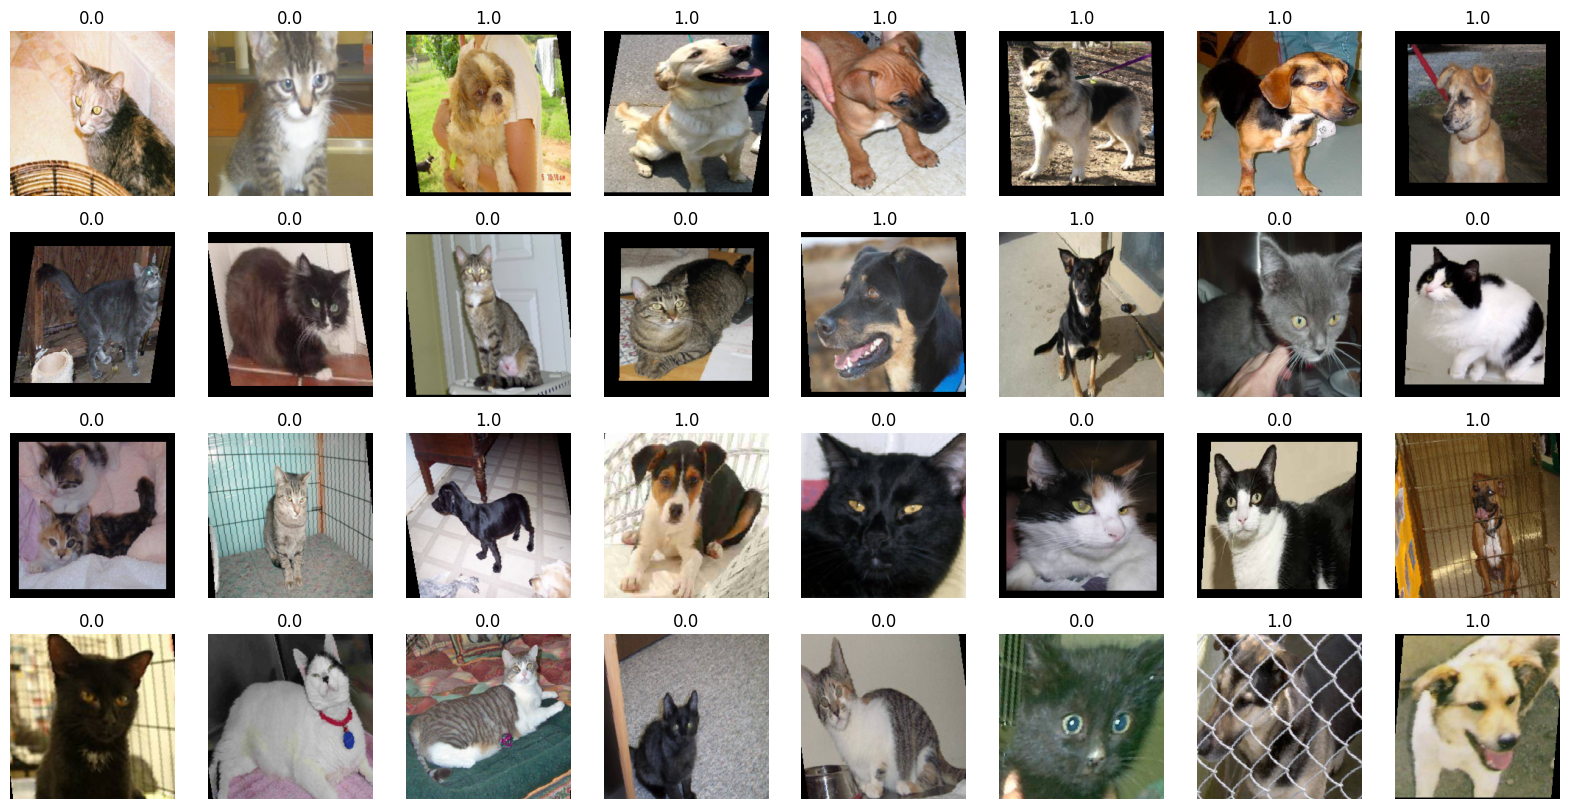

In [71]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))  # 텐서에 저장되어있을 때 shape(컬러, 가로, 세로) -> matplotlib에서는 (가로, 세로, 컬러채널)
  ax.axis('off')

In [72]:
# 파이토치에서 제공하는 model 가져오기
# models.resnet50(pretrained=True).to(device) 와 비슷 -> 미리 학습된 모델을 쓰겠다.
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [73]:
# 미리 학습된(pre-trained) 모델의 일부 파라미터를 고정하고, 나머지 파라미터만 학습하는 "전이 학습"의 일부로 사용
for param in model.parameters():
  param.requires_grad = False  # 가져온 파라미터(W, b)를 업데이트 하지 않음

# 모델의 FC 레이어
model.fc = nn.Sequential(
    nn.Linear(2048, 128),  # 입력 크기가 2048이고 출력 크기가 128인 선형 레이어
    nn.ReLU(),
    nn.Linear(128,1),  # 128차원의 특성을 1차원으로 줄이고, 최종 예측 값을 출력
    nn.Sigmoid()       # 출력을 0과 1 사이로 제한하여 이진 분류 문제에서 확률 값
).to(device)

In [74]:
# 학습: FC 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
  for phase in ['train', 'validation']:  # train과  validation 따로 반복문을 돌아
    if phase == 'train':
      model.train()
    else:
      model.eval()   # 학습 모드에 있던 메모리를 지우고 바로 Test모드(훨씬 빠름)

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:  # train이라면 train에 대한 데이터로더, validataion이라면 validation에 대한 데이터로더 (따로 쓰지 않고 합쳐서 씀)
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')


train     : Epoch    1/10, Loss: 0.1328, Accuracy: 94.63%
validation: Epoch    1/10, Loss: 0.0495, Accuracy: 98.44%
train     : Epoch    2/10, Loss: 0.0845, Accuracy: 96.66%
validation: Epoch    2/10, Loss: 0.0593, Accuracy: 97.66%
train     : Epoch    3/10, Loss: 0.0792, Accuracy: 96.95%
validation: Epoch    3/10, Loss: 0.0497, Accuracy: 98.34%
train     : Epoch    4/10, Loss: 0.0781, Accuracy: 96.97%
validation: Epoch    4/10, Loss: 0.0540, Accuracy: 97.80%
train     : Epoch    5/10, Loss: 0.0703, Accuracy: 97.42%
validation: Epoch    5/10, Loss: 0.0355, Accuracy: 98.88%
train     : Epoch    6/10, Loss: 0.0597, Accuracy: 97.57%
validation: Epoch    6/10, Loss: 0.0372, Accuracy: 98.83%
train     : Epoch    7/10, Loss: 0.0853, Accuracy: 96.37%
validation: Epoch    7/10, Loss: 0.0710, Accuracy: 96.92%
train     : Epoch    8/10, Loss: 0.0742, Accuracy: 97.21%
validation: Epoch    8/10, Loss: 0.0369, Accuracy: 98.88%
train     : Epoch    9/10, Loss: 0.0755, Accuracy: 96.85%
validation: Ep

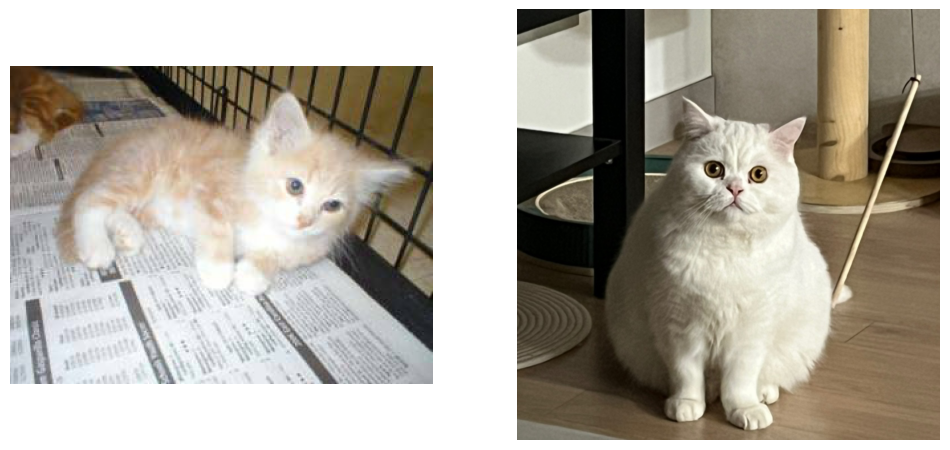

In [111]:
# 테스트
from PIL import Image  # 이미지를 코랩에서 띄우기


img1 = Image.open('/content/test_set/test_set/cats/cat.4245.jpg')   # validation에 있는 이미지 쓰기
img2 = Image.open('/content/뚱냥이.jpg')

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [112]:
img1_input = data_transforms['validation'](img1)  # data_transforms의 validation 키의 value 값에 img1을 통과시킴 -> Resize되고 Tensor로 변환
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [113]:
test_batch = torch.stack([img1_input, img2_input])  # 하나의 이미지 텐서로 결합, 두 이미지를 첫 번째 차원(배치 차원)으로 결합
test_batch = test_batch.to(device)
test_batch.shape   # 두 개 이미지가 붙음, torch.Size([2, 3, 224, 224]): (2(배치크기), 컬러채널, 세로, 가로)

torch.Size([2, 3, 224, 224])

In [114]:
y_pred = model(test_batch)
y_pred

tensor([[0.0013],
        [0.0025]], device='cuda:0', grad_fn=<SigmoidBackward0>)

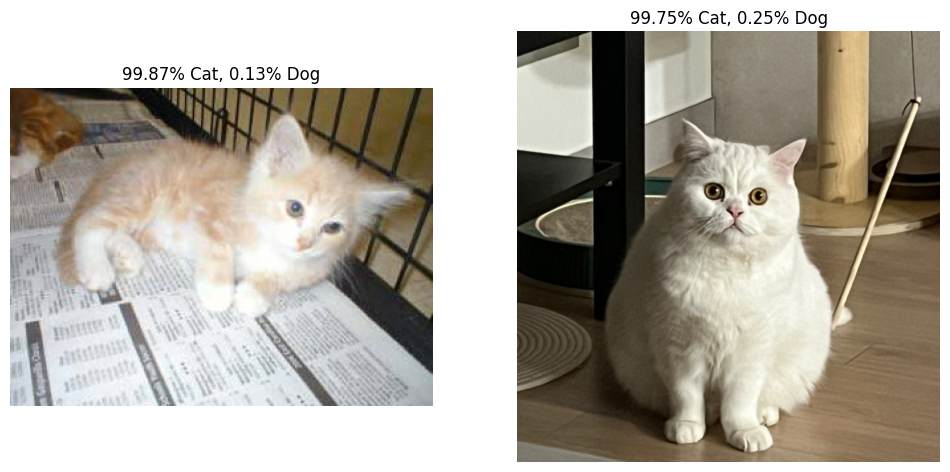

In [115]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% Cat, {y_pred[0,0] * 100:.2f}% Dog')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% Cat, {y_pred[1,0] * 100:.2f}% Dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()